In [1]:
def plot_board(obstacle, beliefState, agent, N):

  from matplotlib import pyplot as plt
  fig, ax = plt.subplots(figsize = (min(N,100),min(N,100)))
  #ax.xaxis.set_ticks_position('top')   #将X坐标轴移到上面
  ax.invert_yaxis()  
  #
  x = [i for i in range(N)]
  y = [i for i in range(N)]
  plt.xlim((0,N))
  #plt.ylim((0,N))
  ax.set_ylim(bottom=N, top=0)  # 此处将原点设置为左上角  
  plt.xticks([0.5 + i for i in range(N )], labels = [str(i) for i in range(N)])
  plt.yticks([0.5 + i for i in range(N)], labels = [str(i) for i in range(N)])
  plt.xlabel('X Axis')
  plt.ylabel('Y Axis')
  width = 1
  height =1 

  for left, bottom in obstacle:
    rect = plt.Rectangle((left, bottom), width, height, facecolor="red", alpha = 1)
    ax.add_patch(rect)

  for left, bottom in beliefState:
    rect = plt.Rectangle((left, bottom), width, height, facecolor="blue", alpha = 0.5)
    ax.add_patch(rect)

  #plt.scatter(agent[0] + 0.5, agent[1] +0.5)
  for i in range(N):
    plt.hlines(i, 0, N , alpha = 0.5)
    plt.vlines(i, 0, N , alpha = 0.5)
  plt.grid(False)
  plt.savefig("obstacle_"+str(N)+".jpg")  
  plt.show()


def move(belief, action):
  result = set()
  for x, y in belief:
    for slip in [1, 2]:
      if action == "w":
        nx, ny = max(0, x - slip) , y
      if action == 'e':
        nx, ny = min(N - 1, x + slip), y
      if action == 'n':
        nx, ny = x, max(0, y - slip)
      if action == 's':
        nx, ny = x, min(N - 1, y + slip)
      result.add((nx, ny))
  return list(result)

In [2]:
def preamble(f):
    print("pomdp", file = f)
    print("observables", file = f)
    print("start", file = f)
    print("endobservables", file = f)
    
def const(f, is_main):
    print("const int N;", file = f)
    print("const int axMAX = N-1;", file = f)
    print("const int ayMAX = N-1;", file = f)
    print("const int axMIN = 0;", file = f)
    print("const int ayMIN = 0;", file = f)
    if is_main:
        print("const int primaryMinX = axMIN;", file = f)
        print("const int primaryMinY = ayMIN;", file = f)
        print("const int primaryMaxX = axMAX;", file = f)
        print("const int primaryMaxY = ayMAX;", file = f)
    else:
        print("const int primaryMinX;", file = f)
        print("const int primaryMinY;", file = f)
        print("const int primaryMaxX;", file = f)
        print("const int primaryMaxY;", file = f)
    print("const int borderSize = 2;", file = f)
    print("const int areaMinX = max(primaryMinX - borderSize, axMIN);", file = f)
    print("const int areaMinY = max(primaryMinY - borderSize, ayMIN);", file = f)
    print("const int areaMaxX = min(primaryMaxX + borderSize, axMAX);", file = f)
    print("const int areaMaxY = min(primaryMaxY + borderSize, ayMAX);", file = f)
    print("const double slippery = 0.1;", file = f)
    
def const_obstacles(obstacles, f):
    for i, (x, y) in enumerate(obstacles):
        print("const int ob{}x = {};".format(i, x), file = f)
        print("const int ob{}y = {};".format(i, y), file = f)

def generate(N, n_obs, n_belief, is_main):
    if N == 6:
        axMAX, ayMAX, axMIN, ayMIN = N - 1, N - 1, 0, 0
        obstacle = [(axMAX - 1, ayMAX - 1), (axMAX, ayMIN + 1), 
                    (axMIN + 1, ayMIN), (axMAX, axMAX - 1),(axMAX -3, ayMAX -1)]
        belief = [(axMAX - 2, ayMAX - 1), (1, 1), (2,1), (1,3)]
        return obstacle, belief
    
    
    import random
    random.seed(N)
    axMax = ayMax = N - 1
    
    obstacles = set()
    while len(obstacles) < n_obs:
        ox = random.randint(0, axMax)
        oy = random.randint(0, ayMax)
        if ox == N - 1 and oy == N - 1:
            continue
        obstacles.add((ox, oy))
        
    if N == 50:
        belief = [(12, 43), (33, 3), (26, 29), (16, 33), (5, 41)]
        return obstacles, belief

    
    belief = set()
    if is_main:
        while len(belief) < n_belief:
            bx = random.randint(0, axMax)
            by = random.randint(0, ayMax)
            if (bx, by) in obstacles or (bx == N - 1 and by == N -1):
                continue
            belief.add((bx, by))
    
    return obstacles, belief

def formula_crash(obstacles, f):
    crash = []
    for i in range(len(obstacles)):
        item = "(ax = ob" + str(i) + "x & "
        item += "ay = ob" + str(i) + "y)" 
        crash.append(item)
    crash = "formula crash = start & (" + "|".join(crash) + ");"
    print(crash, file = f)
    
def formula_done(f, is_main):####
    if is_main:
        done = "formula done = start & ax = axMAX &  ay = ayMAX ;"
    else:
        done =  "formula done = start & (!crash) & ((ax = axMAX & ay = ayMAX) | "
        done += "ax = primaryMaxX + 1 | ax = primaryMaxX + 2 | ay = primaryMaxY + 1 | ay = primaryMaxY + 2 |"
        done += "ax = primaryMinX - 1 | ax = primaryMinX - 2 | ay = primaryMinY - 1 | ay = primaryMinY - 2 ) ;"
    print(done, file = f)
    
def observable(f):
    print("observable \"amdone\" = done;", file = f)
    print("observable \"hascrash\" = crash;", file = f)

def master(f):
    print("module master", file = f)
    print("start : bool init false;", file = f)
    print("[placement] !start -> (start\'=true);", file = f)
    print("[north] start & !done -> true;", file = f)
    print("[south] start  & !done -> true;", file = f)
    print("[east] start  & !done-> true;", file = f)
    print("[west] start & !done -> true;", file = f)
    print("endmodule", file = f)

def robot(initial, is_main, f):#####
    print("module robot", file = f)
    print("ax : [axMIN..axMAX] init axMIN;", file = f)
    print("ay : [ayMIN..ayMAX] init ayMIN;", file = f)
    print("//slipped : bool init false;", file = f)
    
    if is_main:
        #print("[placement] true -> (ax\'=axMIN) & (ay\'=ayMIN);", file = f)
        initial_place = "[placement] true ->"
        for i, (x, y) in enumerate(initial):
            initial_place += " 1/{}:(ax\'={}) & (ay\'={}) +".format(len(initial), x, y) 
        initial_place = initial_place[0:-1] + ";"
        print(initial_place, file = f) # TODO how to ensure it is safe ##


    else:####
        initial_place = ["1/4:(ax\'=primaryMinX) & (ay\'=primaryMinY)", "1/4:(ax\'=primaryMinX) & (ay\'=primaryMaxY)",
                         "1/4:(ax\'=primaryMaxX) & (ay\'=primaryMinY)", "1/4:(ax\'=primaryMaxX) & (ay\'=primaryMaxY)"]
        
        #initial_place = ["1/2:(ax\'=primaryMinX) & (ay\'=primaryMaxY)",
        #                 "1/2:(ax\'=primaryMaxX) & (ay\'=primaryMinY)"]
        
        print("[placement] true ->" + " + ".join(initial_place) + ";", file = f)

    print("[west] true -> (1-slippery): (ax\'=max(ax-1,areaMinX)) + slippery: (ax\'=max(ax-2,areaMinX));", file = f)
    print("[east] true -> (1-slippery): (ax\'=min(ax+1,areaMaxX)) + slippery: (ax\'=min(ax+2,areaMaxX));", file = f)
    print("[south]  true -> (1-slippery): (ay\'=min(ay+1,areaMaxY)) + slippery: (ay\'=min(ay+2,areaMaxY));", file = f)
    print("[north]  true -> (1-slippery): (ay\'=max(ay-1,areaMinY)) + slippery: (ay\'=max(ay-2,areaMinY));", file = f)
    print("endmodule", file = f)


def label(f):
    print("label \"goal\" = done;", file = f)
    print("label \"traps\" = crash;", file = f)
    print("label \"notbad\" =  !crash;", file = f)

def reward(f, crash):
    print("rewards \"cost\"", file = f)
    print("[north] true : 1;", file = f)
    print("[south] true : 1;", file = f)
    print("[west] true : 1;", file = f)
    print("[east] true : 1;", file = f)
    print("crash: {};".format(crash), file = f)
    print("endrewards", file = f)
    
    print("rewards \"cos\"", file = f)
    print("[north] true : 1;", file = f)
    print("[south] true : 1;", file = f)
    print("[west] true : 1;", file = f)
    print("[east] true : 1;", file = f)
    print("crash: {};".format(crash), file = f)
    print("endrewards", file = f)   
    
    print("rewards \"rew\"", file = f)
    print("done : 20;", file = f)
    print("endrewards", file = f)
    
def display(filename):
    file1 = open(filename, 'r')
    Lines = file1.readlines()
    count = 0
    # Strips the newline character
    for line in Lines:
        count += 1
        print("Line{}: {}".format(count, line.strip()))
    file1.close()

[(3, 4), (1, 1), (2, 1), (1, 3)]
[(3, 4), (1, 1), (2, 1), (1, 3)]


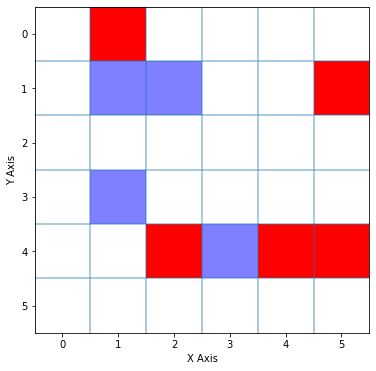

[(12, 43), (33, 3), (26, 29), (16, 33), (5, 41)]
[(12, 43), (33, 3), (26, 29), (16, 33), (5, 41)]


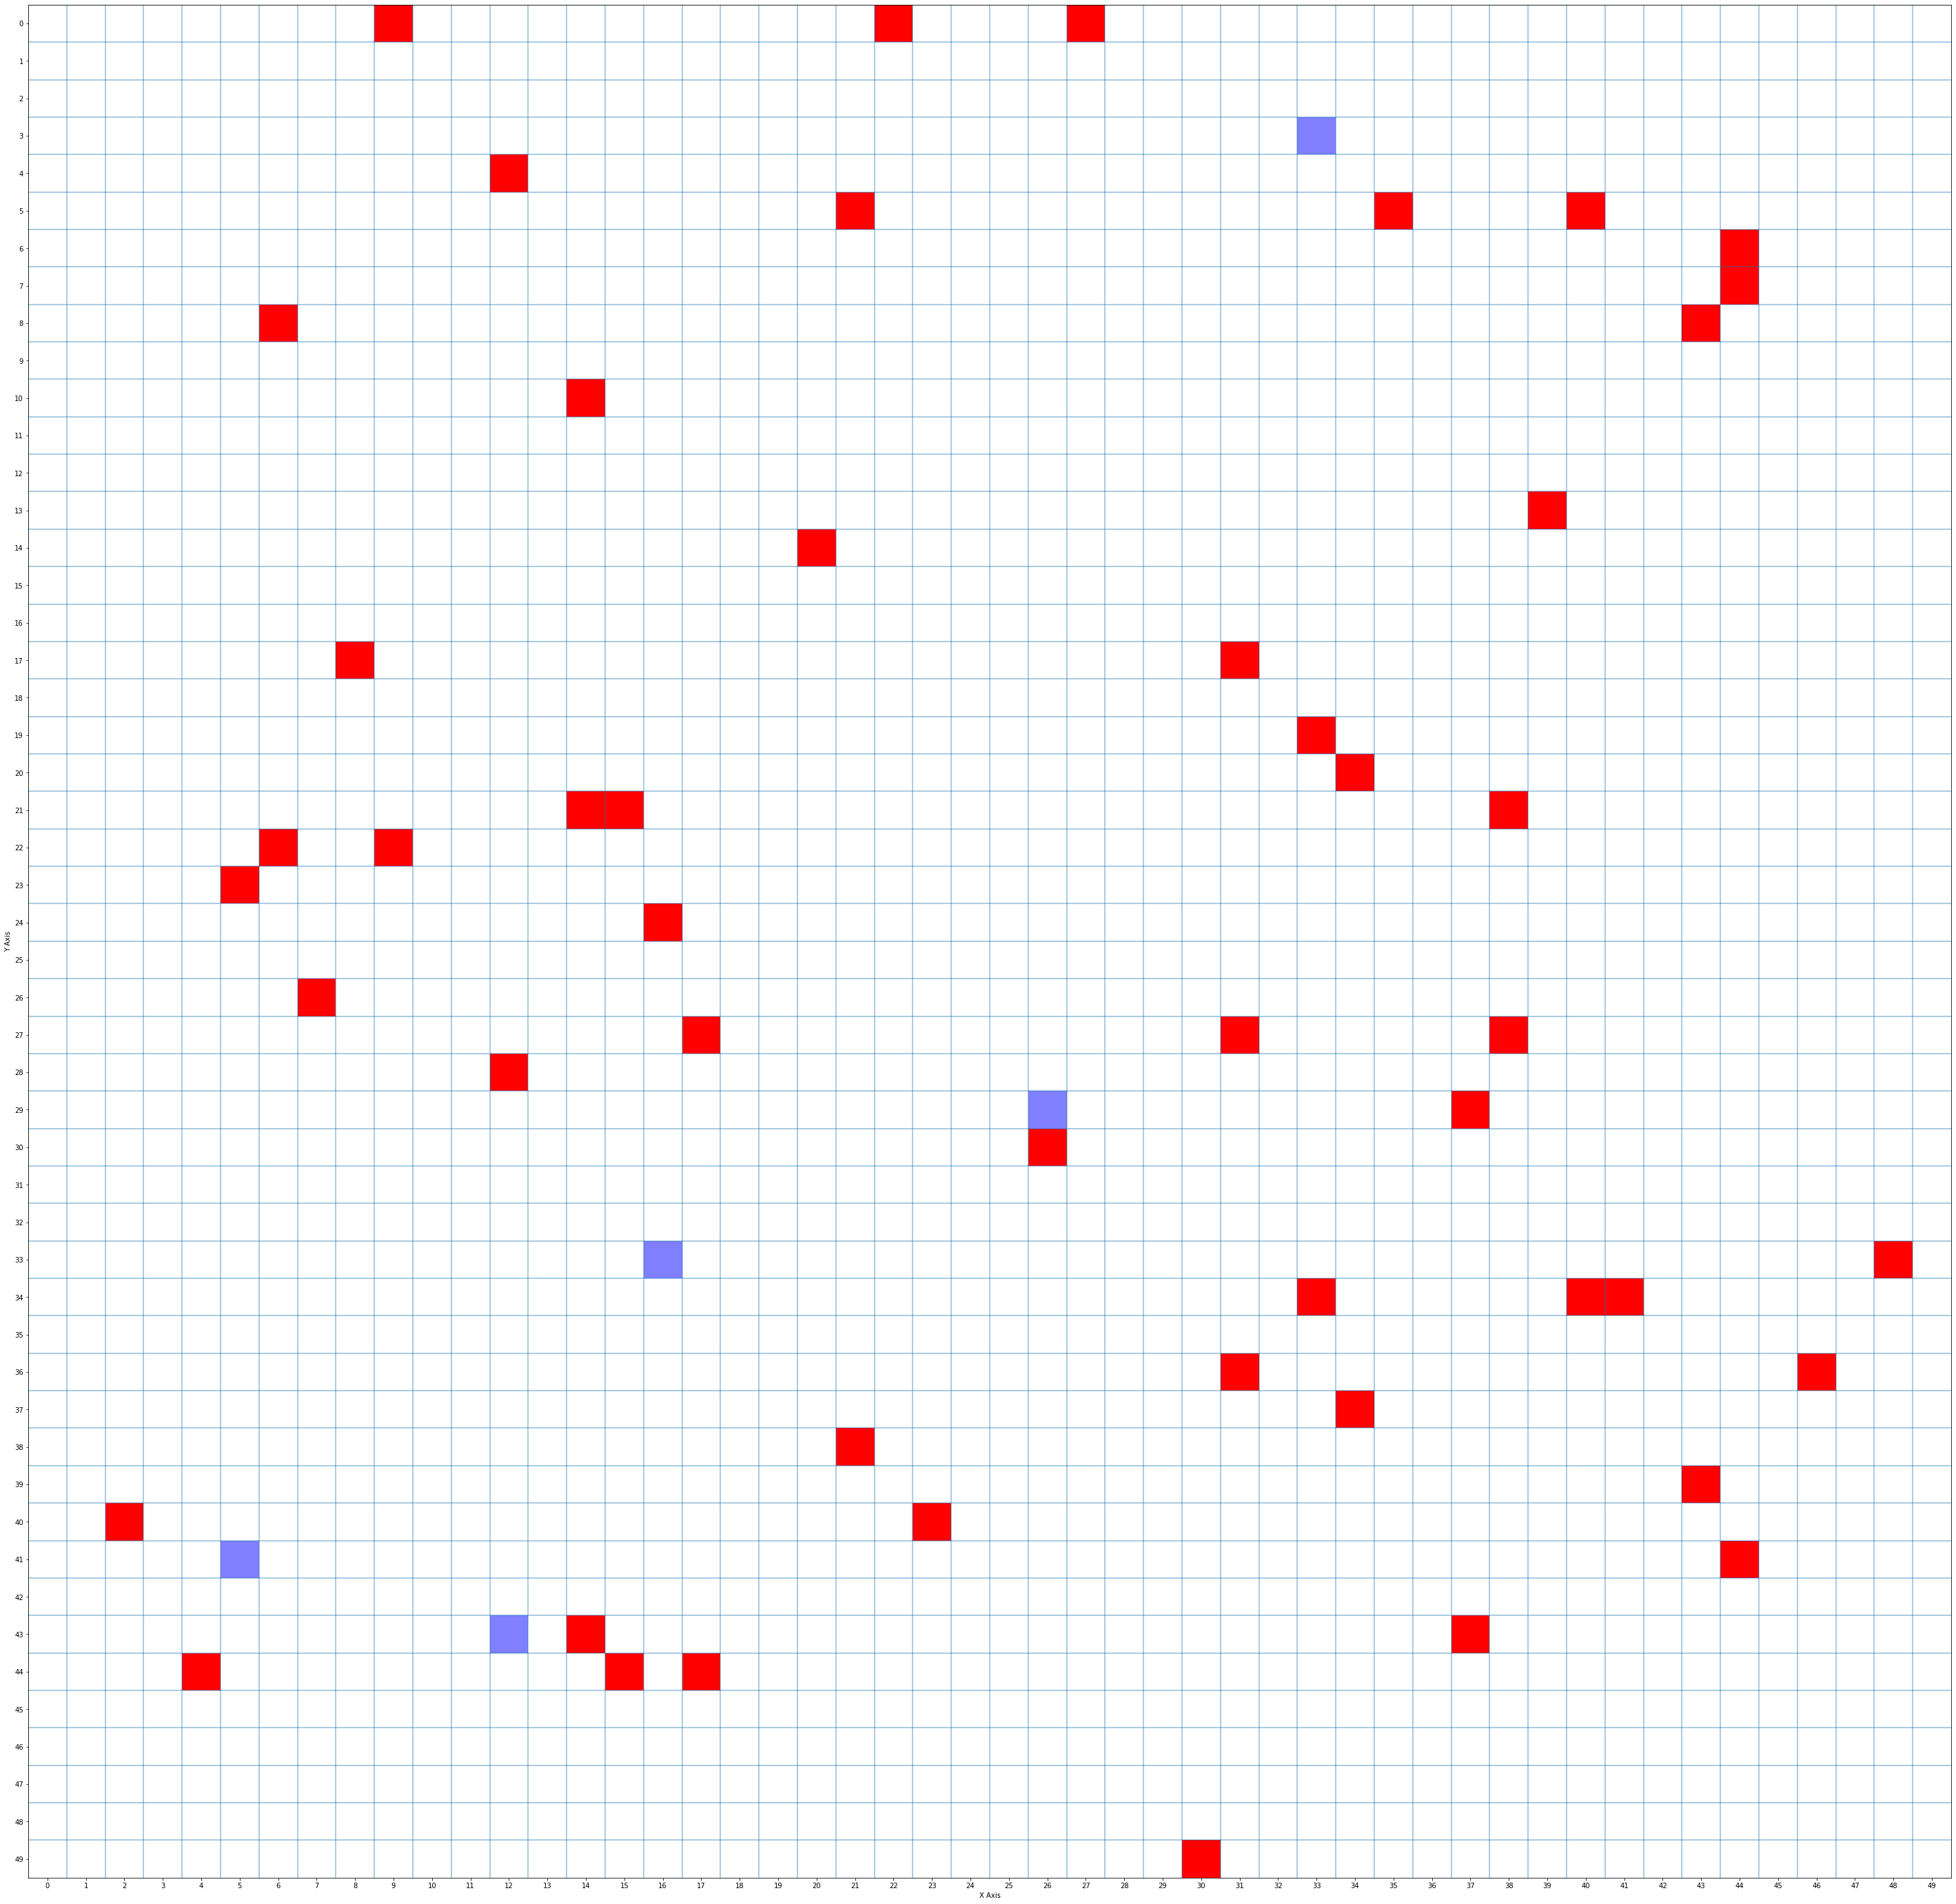

set()
{(4, 3), (34, 0), (29, 51), (34, 38), (71, 37)}


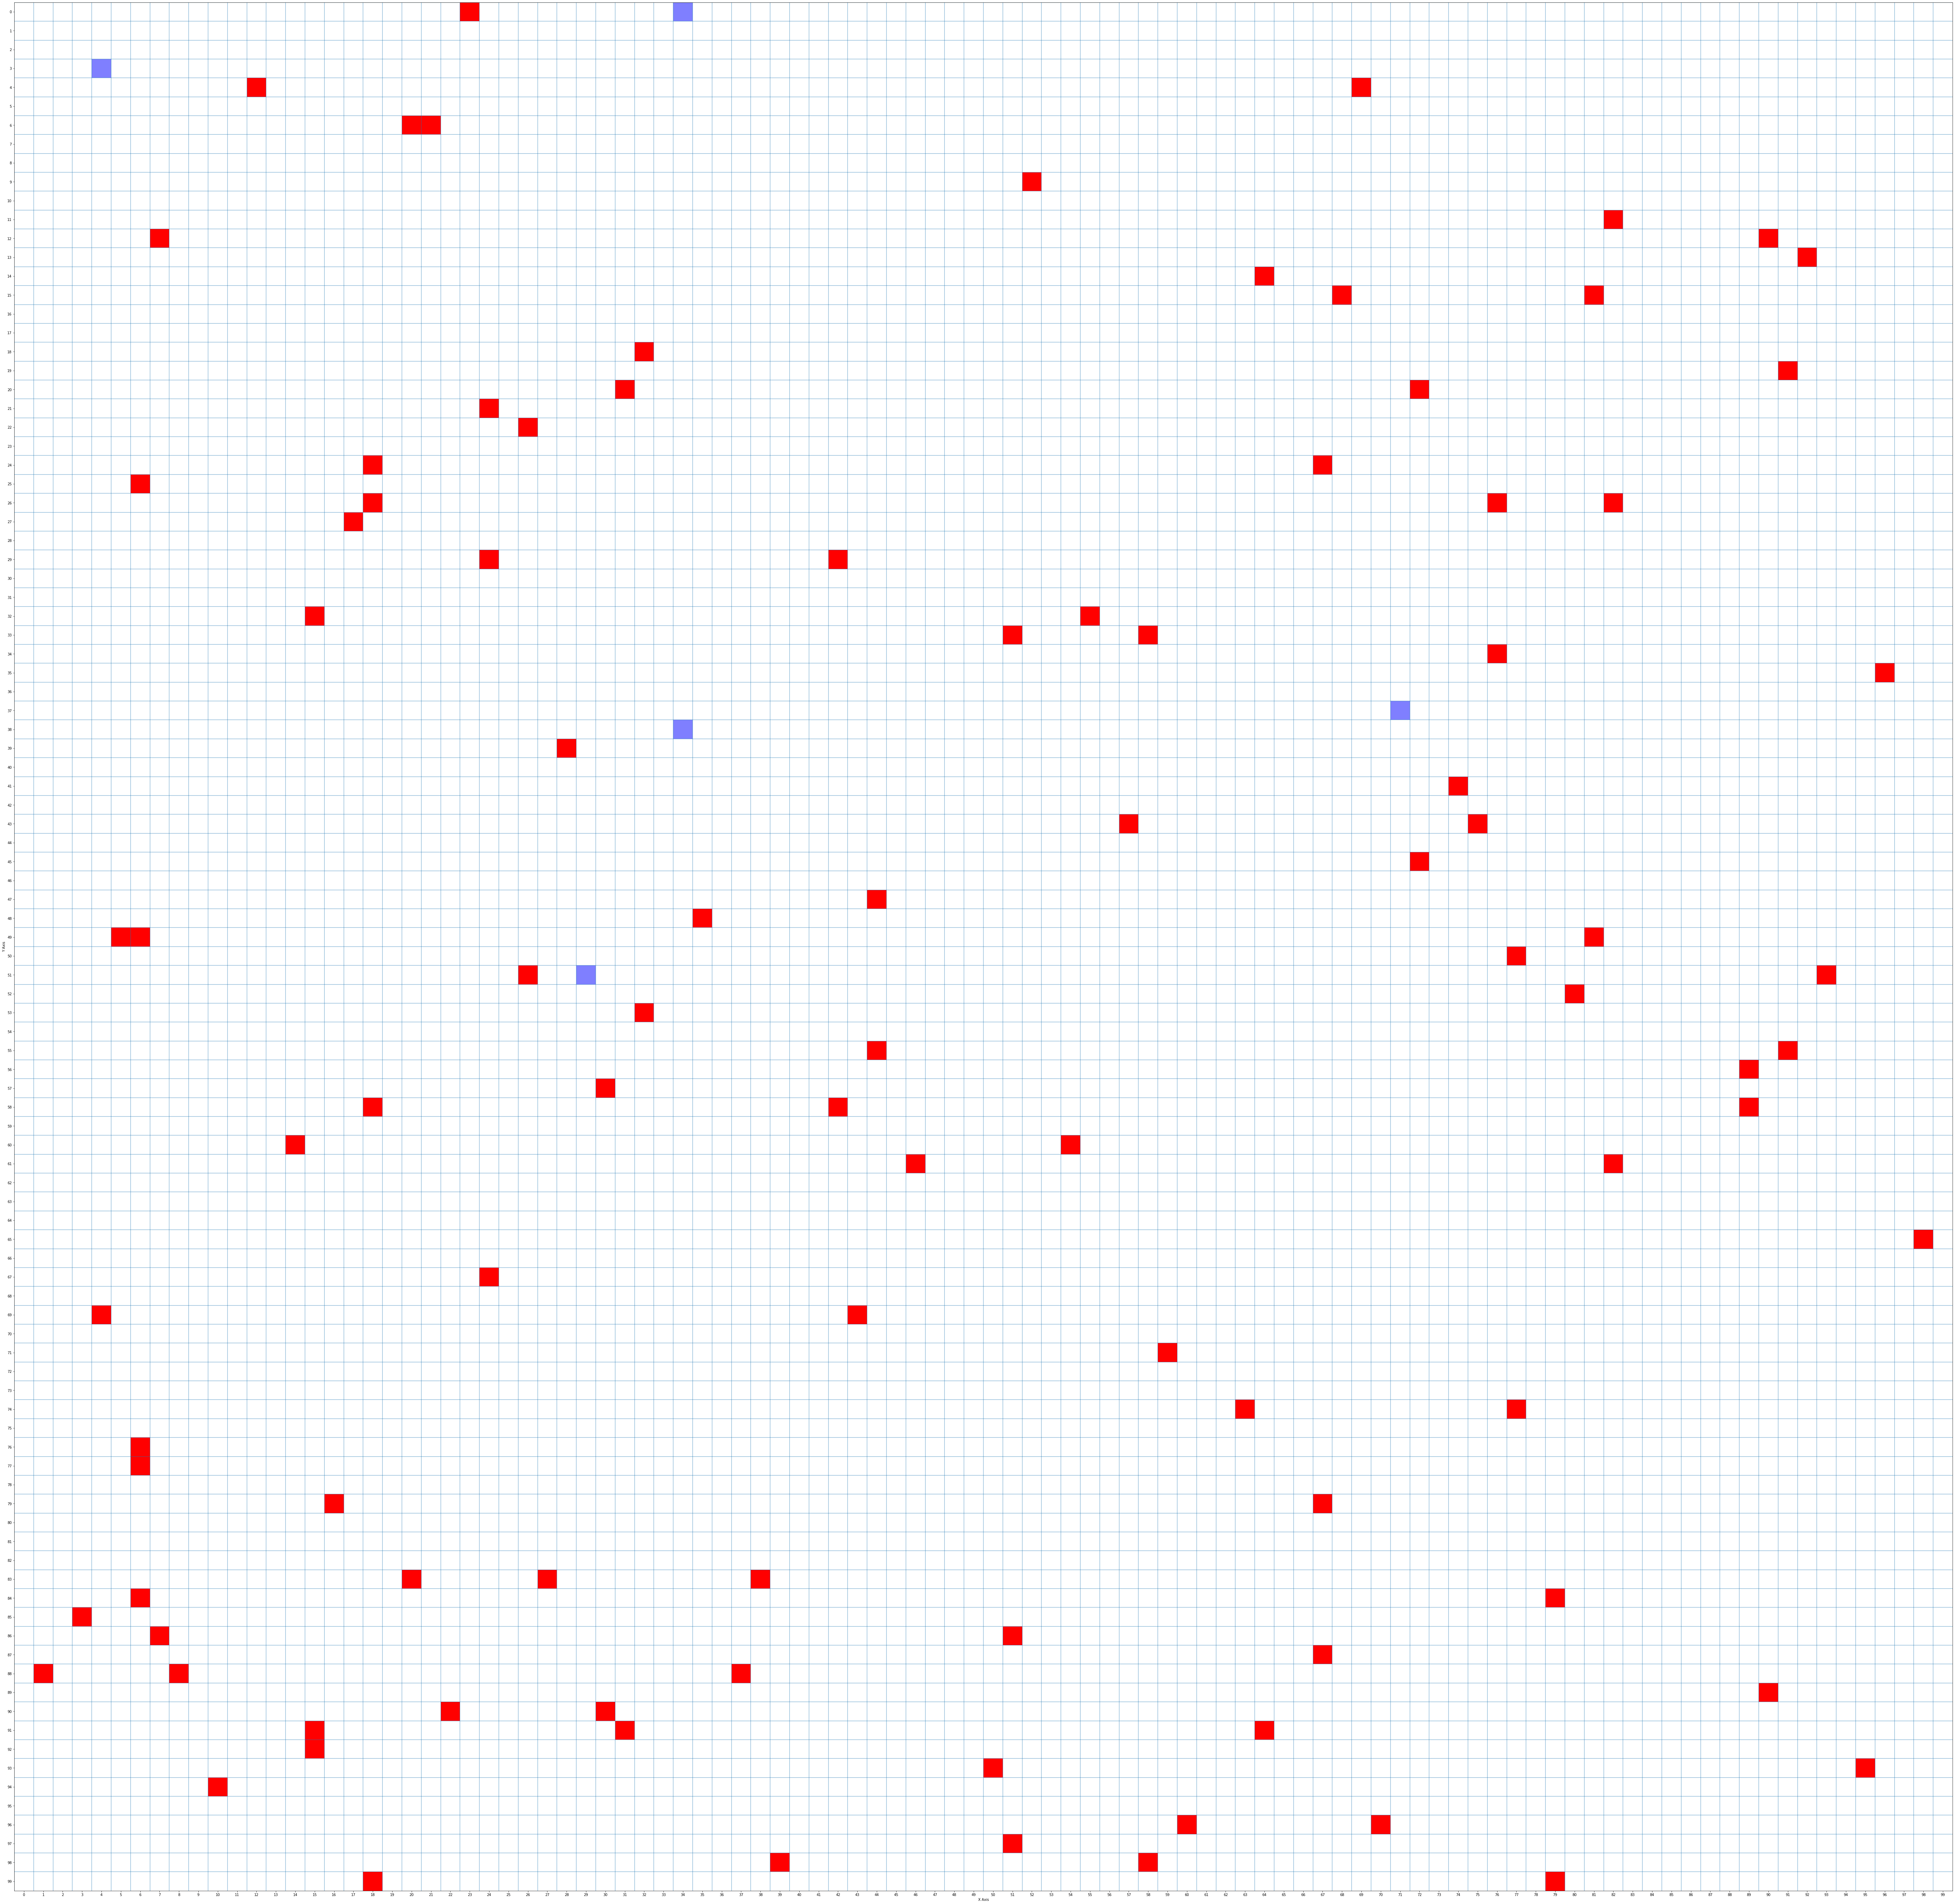

set()
{(157, 287), (63, 279), (262, 382), (120, 446), (293, 76)}


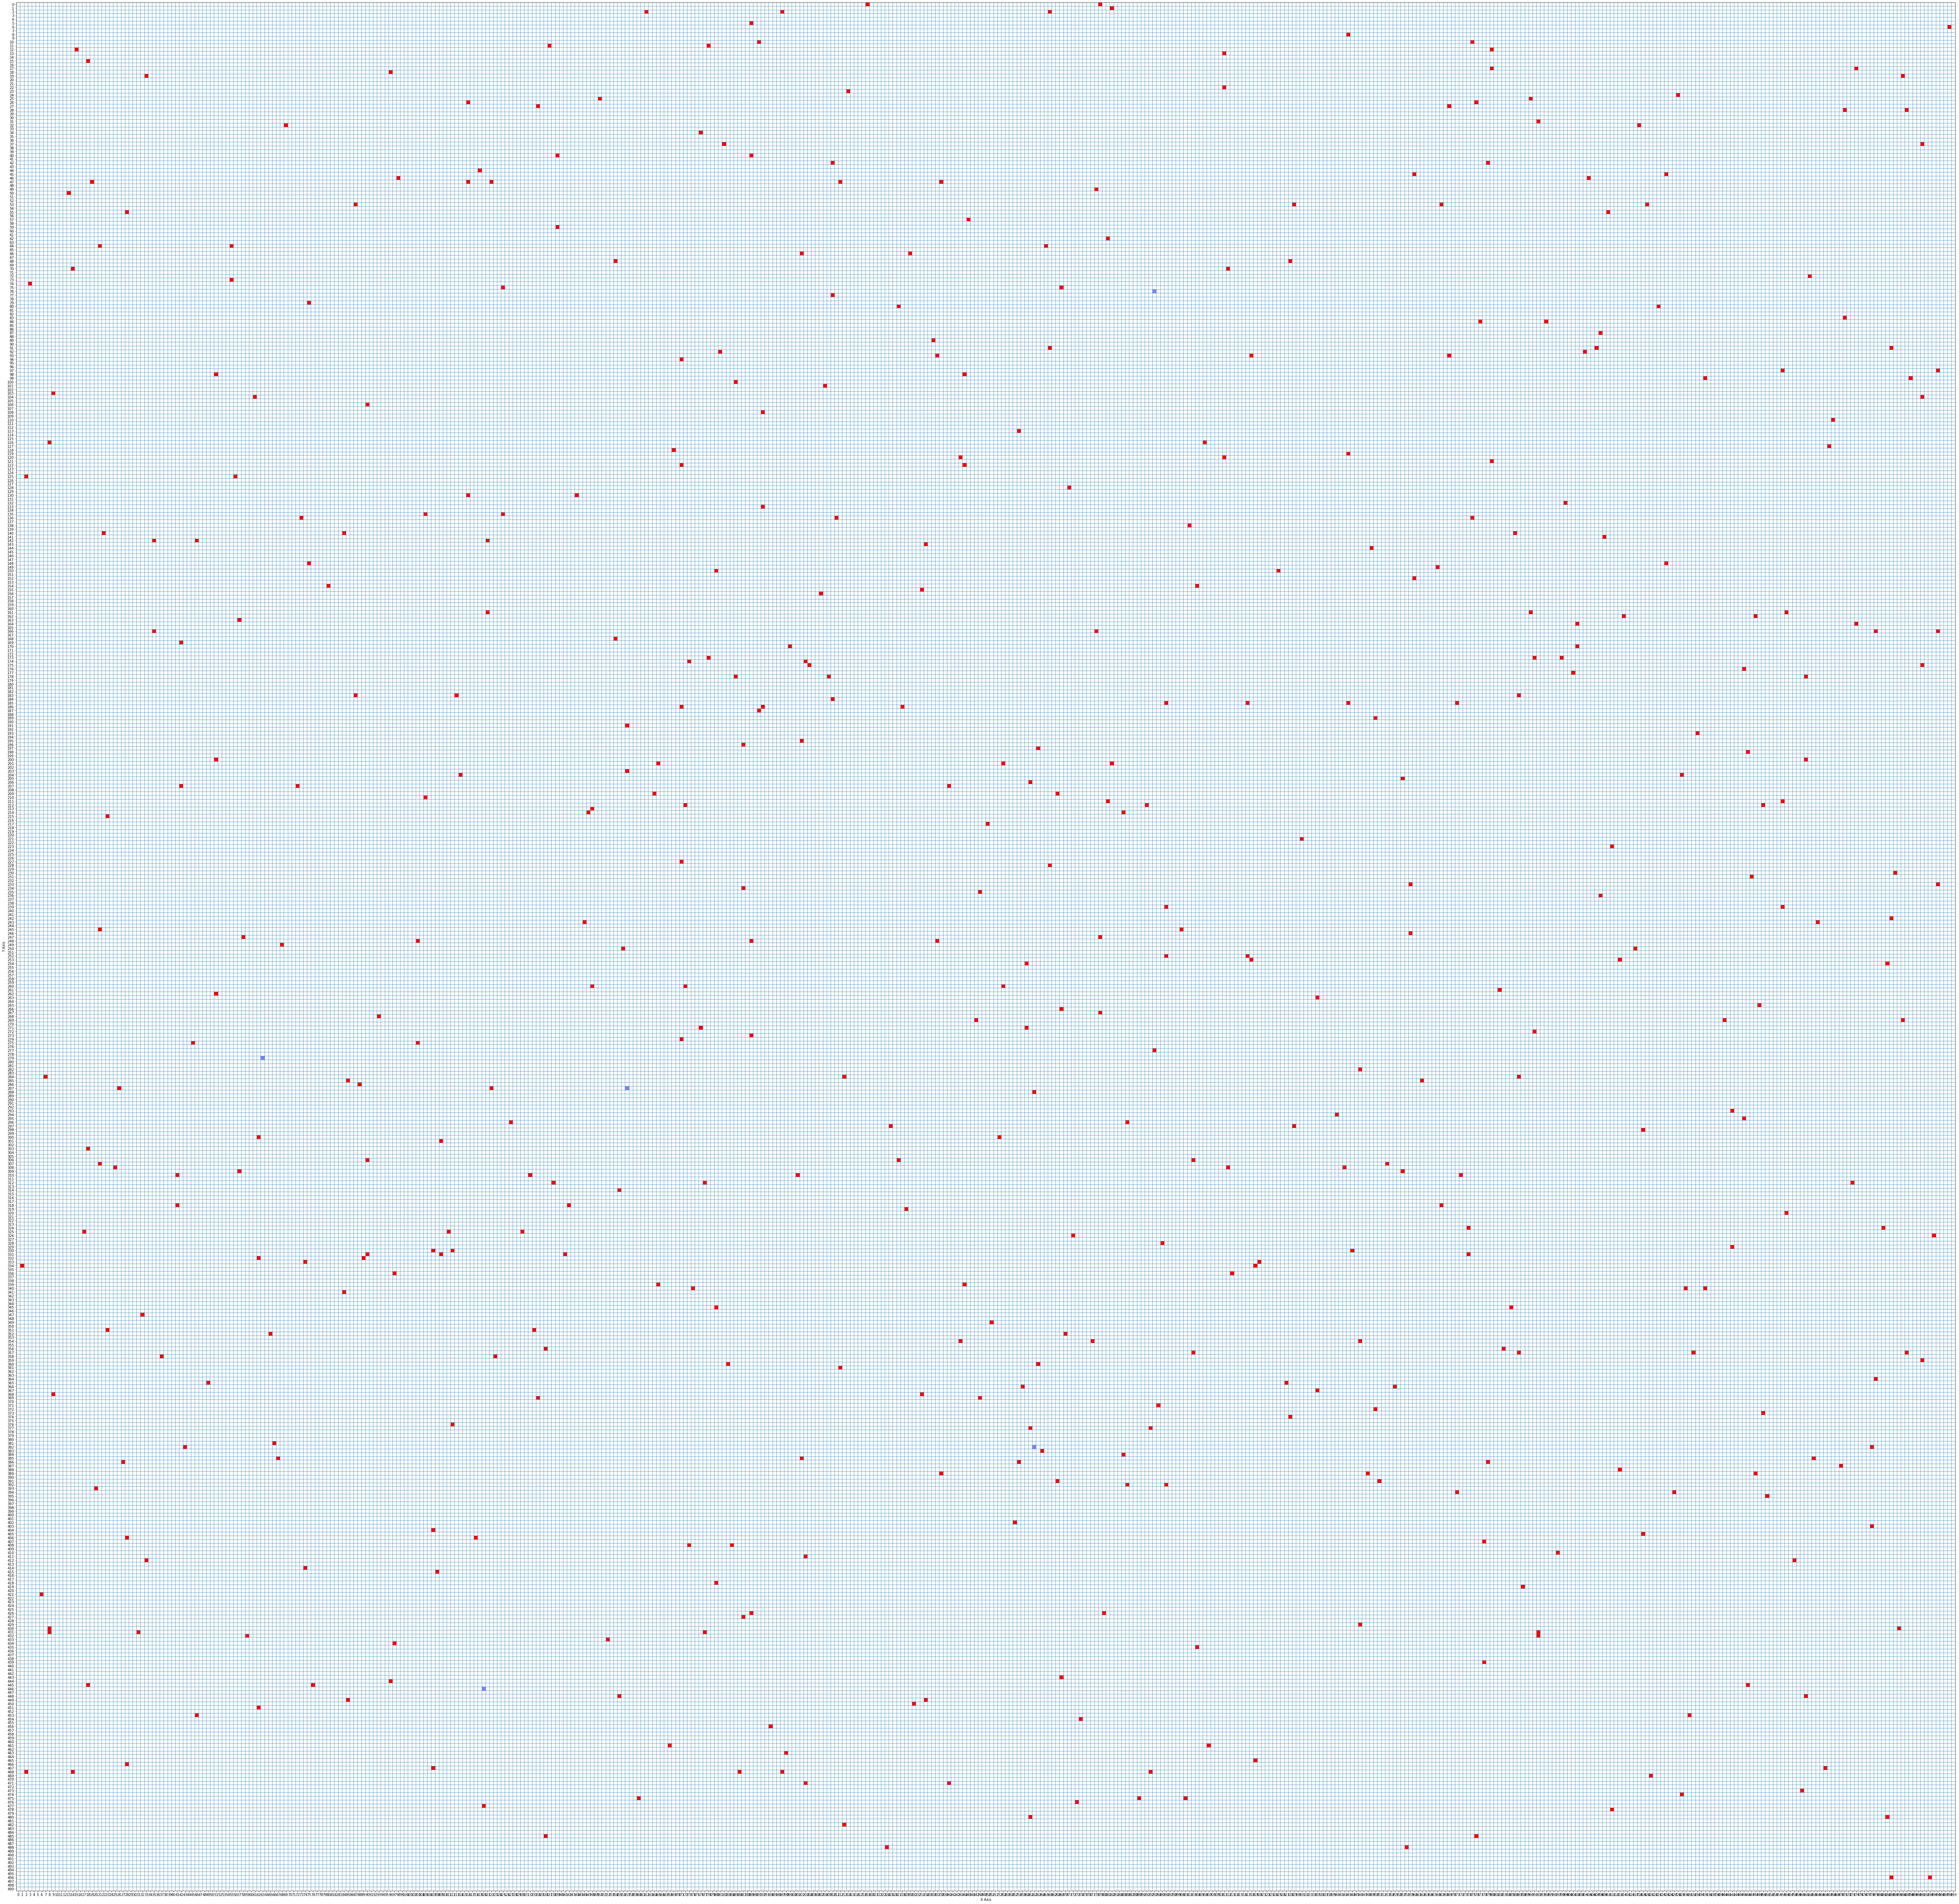

In [3]:
def main(file_name = "", N = 6, primaryMinX = None, primaryMinY = None, primaryMaxX = None, primaryMaxY = None, is_main = True, crash = 5):
    
    file_name += "./N" + str(N)+"/"
    if is_main:
        file_name += "obstacle_" + str(N) + "_centralized"
    else:
        file_name += "obstacle_" + str(N) + "_factored"
    
    n_obs = N
    n_belief = 5
    
    obstacles, initial = generate(N, n_obs, n_belief, is_main)
    
    with open(file_name + '.nm', 'w') as f:
        preamble(f)
        const(f, is_main)
        const_obstacles(obstacles, f)
        formula_crash(obstacles, f)
        formula_done(f, is_main)
        observable(f)
        master(f)
        robot(initial, is_main, f) # if main file, specify the intial states; else local files, intitial states no matter
        label(f)
        reward(f, crash)
    f.close()
    print(initial)
    #display(file_name + '.nm')
    if is_main:
        plot_board(obstacles, initial, (0, 0), N)
    
if __name__ == "__main__":
    
    grid =[
         6, 
        50,
         100,
         500
    ]
    
    for N in grid:
        main(N = N, is_main = False)
        main(N = N, is_main = True)


    #main(N = 50, is_main = True)
    #main(N = 50, is_main = False)

#     main(N = 100, is_main = True)
#     main(N = 100, is_main = False)


#     main(N = 1000, is_main = True)
#     main(N = 1000, is_main = False)
    

In [4]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [5]:
def index_to_num(index):
    tp = 0
    for i in index:
        bucket = i // 64
        indexInBucket = 63 - (i - 64 * bucket)
        tp += 2 ** indexInBucket
    return tp
index_to_num([3])

def num_to_bin(num):
    tp = bin(num).replace("0b", "")
    while len(tp) < 64:
        tp = '0' + tp
    return tp

a= num_to_bin(num)
len(a)
print(a)

NameError: name 'num' is not defined

In [ ]:
nums = [index_to_num([3]), 10016005571271983104, 10160120759347838976, 14411518807585587200, 18410715276690587648]
for n in nums:
    binary = num_to_bin(n)
    print(binary, len(binary))